# Инициализация модели

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, pearsonr

In [18]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

In [19]:
class IdeologicalPolarizationModel:
    """
    Simulates ideological polarization by modeling agents' self-position and perceptions
    of Democratic and Republican parties, including in-group bias, out-group discrimination
    and probabilistic perception errors.
    """
    def __init__(self,
                 n_agents=100,
                 n_iterations=100,
                 dem_pos=3,
                 rep_pos=7,
                 perception_std=1.5,
                 probability_logical_perception=0.8,
                 beta_self_dem=0.35,
                 beta_self_rep=0.1,
                 beta_self_dem_rep=0.8,
                 rep_identity_boost_range=(1.0, 2.0),
                 random_seed=None):
        """
        Parameters
        ----------
        n_agents : int
            Number of agents.
        n_iterations : int
            Number of iterations to average results.
        dem_pos : int
            Fixed ideological position of Democratic party on a 0-10 scale.
        rep_pos : int
            Fixed ideological position of Republican party on a 0-10 scale.
        perception_std : float
            Standard deviation for perception noise.
        probability_logical_perception : float
            Probability that agent perceives their party position logically.
        beta_self_dem : float
            Effect of Democrats' ideological distance from Republicans on perceived Republican position (out-group discrimination).
        beta_self_rep : float
            Effect of Republicans' self-position on their perception of Republicans (closer to center => moderate perception, else => radical perception; in-group projection).
        beta_self_dem_rep : float
            Effect of Republicans' self-position on their perception of Democrats (out-group discrimination).
        rep_identity_boost_range : tuple(float, float)
            Range from which to sample in-group identity exaggeration for Republicans (in-group bias).
        random_seed : int or None
            Random seed for reproducibility.
        """
        self.n_agents = n_agents
        self.n_iterations = n_iterations
        self.dem_pos = dem_pos
        self.rep_pos = rep_pos
        self.perception_std = perception_std
        self.probability_logical_perception = probability_logical_perception
        self.beta_self_dem = beta_self_dem
        self.beta_self_rep = beta_self_rep
        self.beta_self_dem_rep = beta_self_dem_rep
        self.rep_identity_boost_range = rep_identity_boost_range

        if random_seed is not None:
            np.random.seed(random_seed)

    def run_single_iteration(self):
        # Assign party: 0 = Dem, 1 = Rep
        party = np.random.choice([0, 1], size=self.n_agents, p=[0.5, 0.5])

        # Determine mean self-position: mostly logical perception with some flips
        rand_vals = np.random.rand(self.n_agents)
        self_position_mean = np.where(
            rand_vals < self.probability_logical_perception,
            np.where(party == 0, self.dem_pos, self.rep_pos),
            np.where(party == 0, self.rep_pos, self.dem_pos)
        )

        # Draw actual self positions with noise
        self_position = (np.random.normal(self_position_mean, self.perception_std, size=self.n_agents))
        self_position = np.clip(self_position, 0, 10)

        # Initialize perceptions of parties
        perceived_dem = np.zeros(self.n_agents)
        perceived_rep = np.zeros(self.n_agents)

        # Masks for party groups
        mask_dem = (party == 0)
        mask_rep = (party == 1)

        # Democrats perceive Dem party roughly as their own position plus noise
        perceived_dem[mask_dem] = (
            self_position[mask_dem] +
            np.random.normal(0, self.perception_std, size=np.sum(mask_dem))
        )

        # Dems exaggerate Republican extremity => negative correlation
        perceived_rep[mask_dem] = (
            self.rep_pos +
            self.beta_self_dem * (self.rep_pos - self_position[mask_dem]) +
            np.random.normal(0, self.perception_std, size=np.sum(mask_dem))
        )

        # Republicans perceive Republican party with in-group bias and in-group projection
        rep_identity_boost = np.random.uniform(
            self.rep_identity_boost_range[0],
            self.rep_identity_boost_range[1],
            size=np.sum(mask_rep)
        )

        perceived_rep[mask_rep] = (
            self.rep_pos +
            rep_identity_boost +
            self.beta_self_rep * (self_position[mask_rep] - self.rep_pos) +
            np.random.normal(0, self.perception_std, size=np.sum(mask_rep))
        )

        # Republicans perceive Dems contrastingly with negative slope and noise
        perceived_dem[mask_rep] = (
            self.dem_pos +
            self.beta_self_dem_rep * (self.dem_pos - self_position[mask_rep]) +
            np.random.normal(0, self.perception_std, size=np.sum(mask_rep))
        )

        # Clip perceptions to valid range
        perceived_rep = np.clip(perceived_rep, 0, 10)
        perceived_dem = np.clip(perceived_dem, 0, 10)

        # Calculate left-right distance between perceived parties, direction depends on party
        lr_distance_parties = np.where(
            party == 0,
            perceived_dem - perceived_rep,
            perceived_rep - perceived_dem
        )

        df = pd.DataFrame({
            "self": self_position,
            "perc_dem": perceived_dem,
            "perc_rep": perceived_rep,
            "party": party,
            "lr_distance_parties": lr_distance_parties
        })

        return df

    def compute_statistics(self, df):
        stats = {}

        # Basic stats for 'self', 'perc_dem', 'perc_rep'
        for col in ['self', 'perc_dem', 'perc_rep']:
            stats[f'{col}_mean'] = df[col].mean()
            stats[f'{col}_std'] = df[col].std()
            stats[f'{col}_skew'] = skew(df[col].dropna())

        # Differences
        df['diff_self_dem'] = df['self'] - df['perc_dem']
        df['diff_self_rep'] = df['self'] - df['perc_rep']
        df['diff_dem_rep'] = df['perc_dem'] - df['perc_rep']

        for col in ['diff_self_dem', 'diff_self_rep', 'diff_dem_rep']:
            stats[f'{col}_mean'] = df[col].mean()
            stats[f'{col}_std'] = df[col].std()
            stats[f'{col}_skew'] = skew(df[col].dropna())

        # Correlations for all, dems, reps
        for group, label in [(None, 'all'), (0, 'dems'), (1, 'reps')]:
            subset = df if group is None else df[df['party'] == group]

            try:
                stats[f'corr_self_dem_{label}'] = pearsonr(subset['self'], subset['perc_dem'])[0]
                stats[f'corr_self_rep_{label}'] = pearsonr(subset['self'], subset['perc_rep'])[0]
                stats[f'corr_dem_rep_{label}'] = pearsonr(subset['perc_dem'], subset['perc_rep'])[0]
            except Exception:
                stats[f'corr_self_dem_{label}'] = np.nan
                stats[f'corr_self_rep_{label}'] = np.nan
                stats[f'corr_dem_rep_{label}'] = np.nan

        return stats, df

    def run(self):
        all_stats = []
        for _ in range(self.n_iterations):
            df = self.run_single_iteration()
            stats, _ = self.compute_statistics(df)
            all_stats.append(stats)
        return pd.DataFrame(all_stats).mean().to_frame(name='mean_value')

## Heatmap для всех переменных

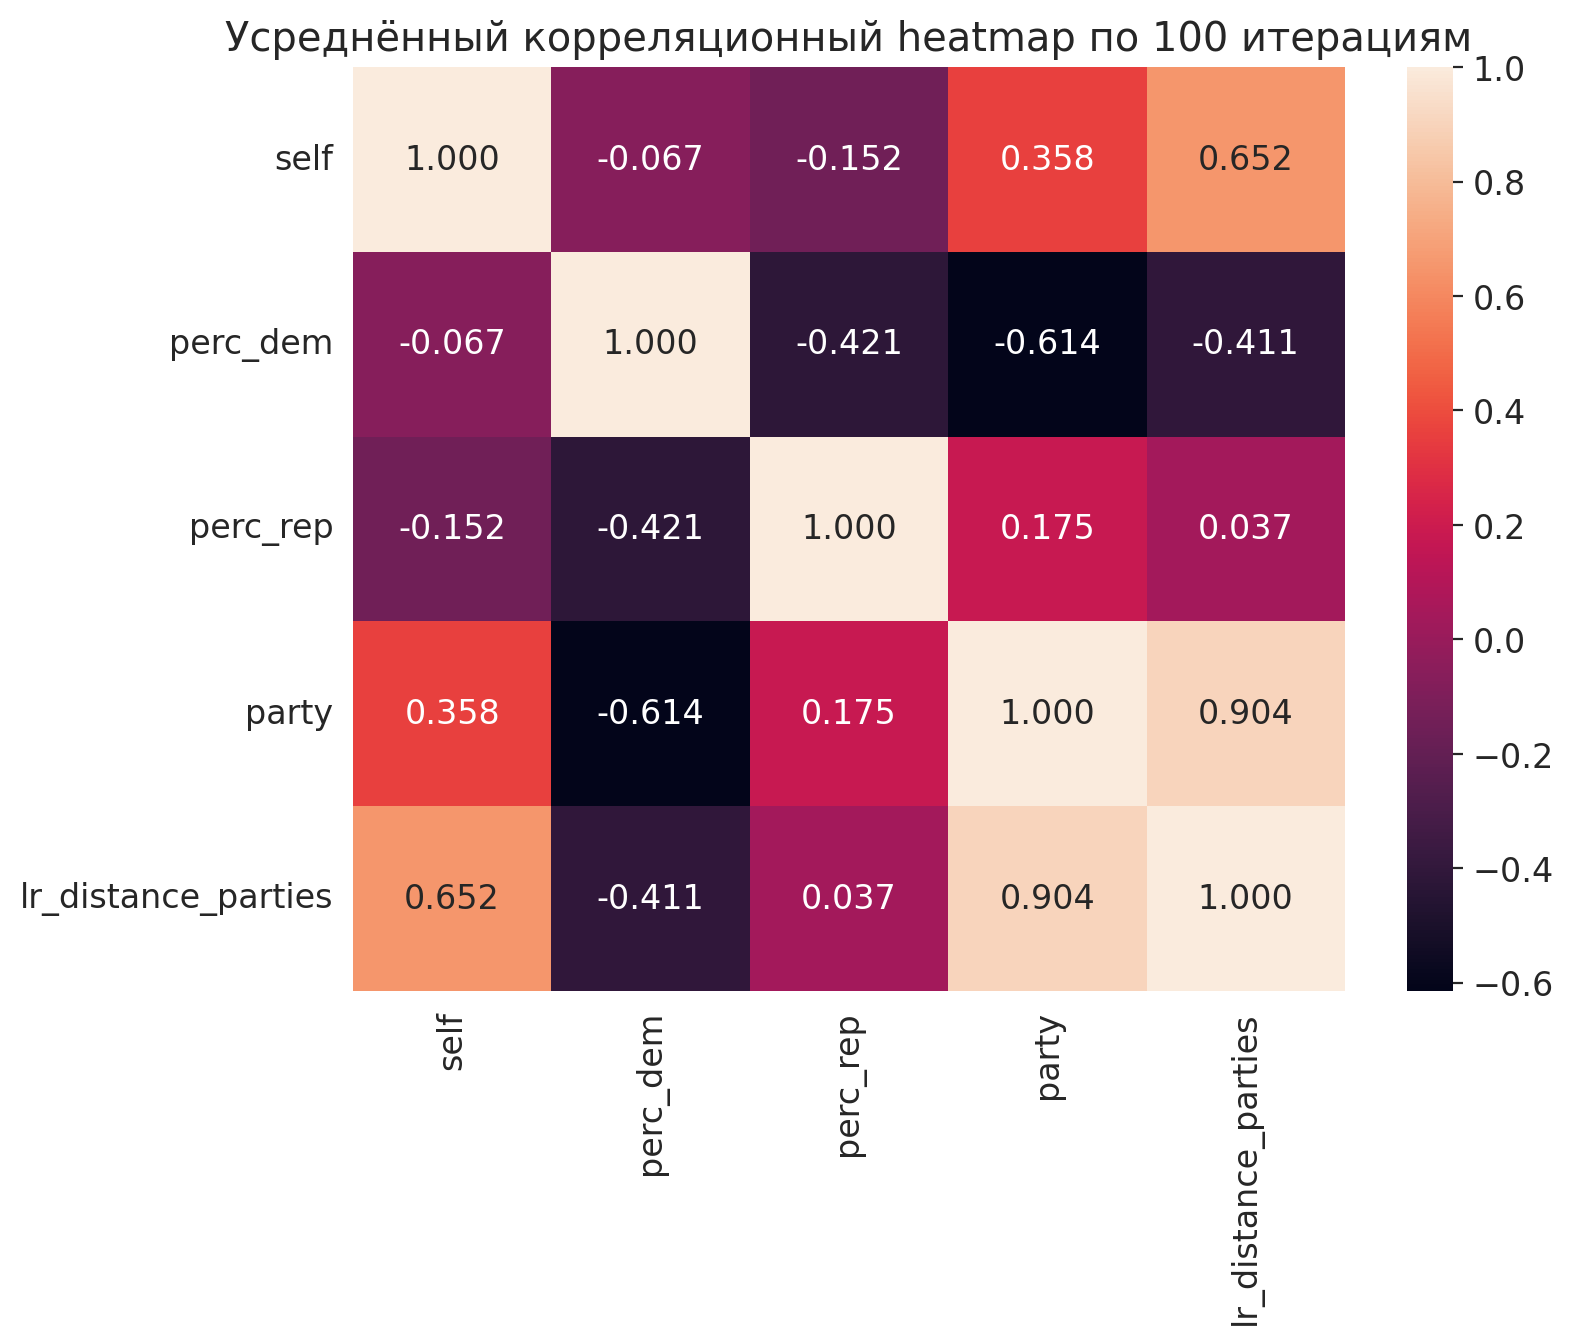

In [27]:
model = IdeologicalPolarizationModel(
    n_agents=100000,
    probability_logical_perception=0.7,
    perception_std=1.0,
    rep_pos=7,
    dem_pos=3
)

n_iterations = 100
corr_matrices = []

for _ in range(n_iterations):
    df = model.run_single_iteration()
    corr = df.corr()
    corr_matrices.append(corr)

# Averaging correlations to account for noise
mean_corr = sum(corr_matrices) / n_iterations

plt.figure(figsize=(8, 6))
sns.heatmap(mean_corr, annot=True, fmt=".3f")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Усреднённый корреляционный heatmap по 100 итерациям")
plt.show()

## Heatmap'ы отдельно для демократов и республиканцев

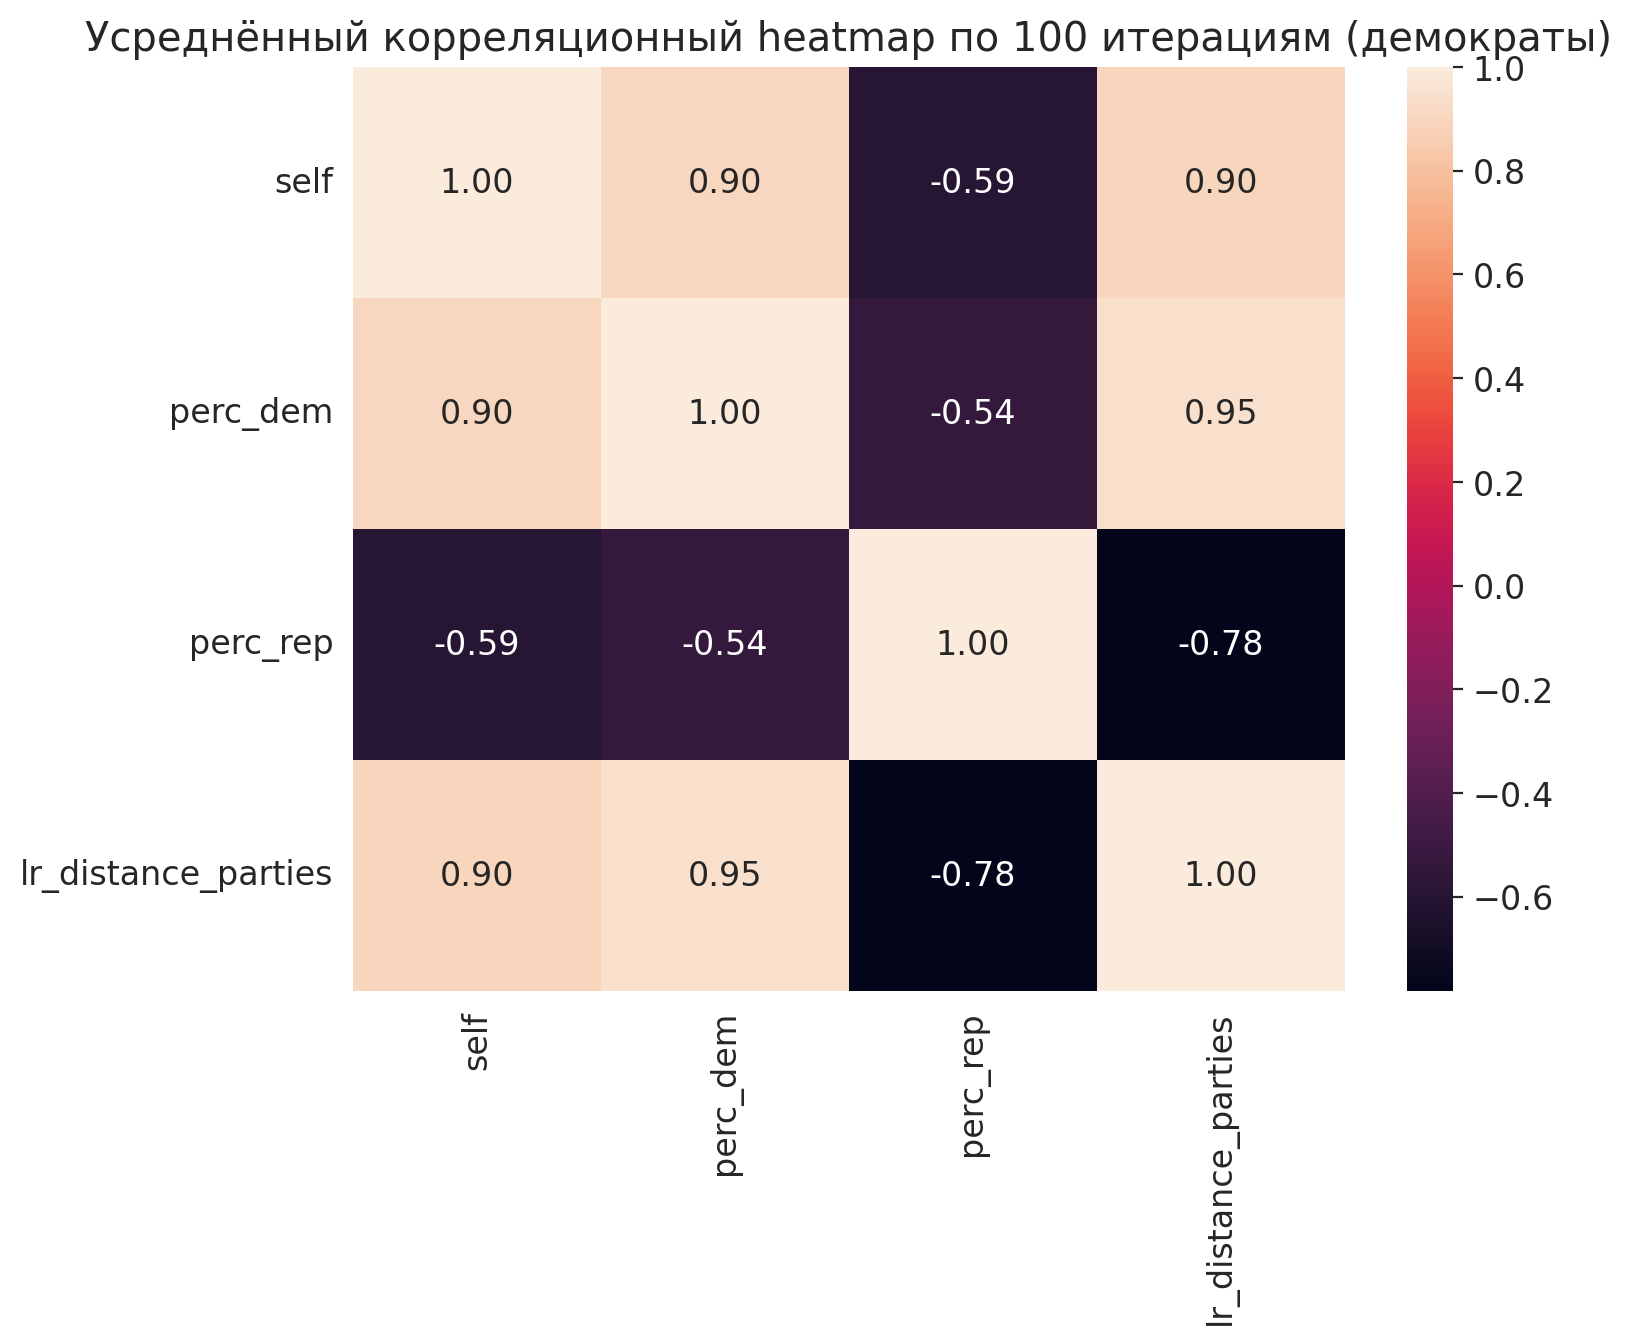

In [28]:
n_iterations = 100
corr_matrices = []

party_of_interest = 0  # 0 - Демократы, 1 - Республиканцы

for _ in range(n_iterations):
    df = model.run_single_iteration()
    df_party = df[df['party'] == party_of_interest]  # фильтр по партии
    corr = df_party.corr()
    corr_matrices.append(corr)

# Averaging correlations to account for noise
mean_corr = sum(corr_matrices) / n_iterations

plt.figure(figsize=(8, 6))
sns.heatmap(mean_corr.drop(index='party', columns='party'), annot=True, fmt=".2f")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title(f"Усреднённый корреляционный heatmap по 100 итерациям (демократы)")
plt.show()

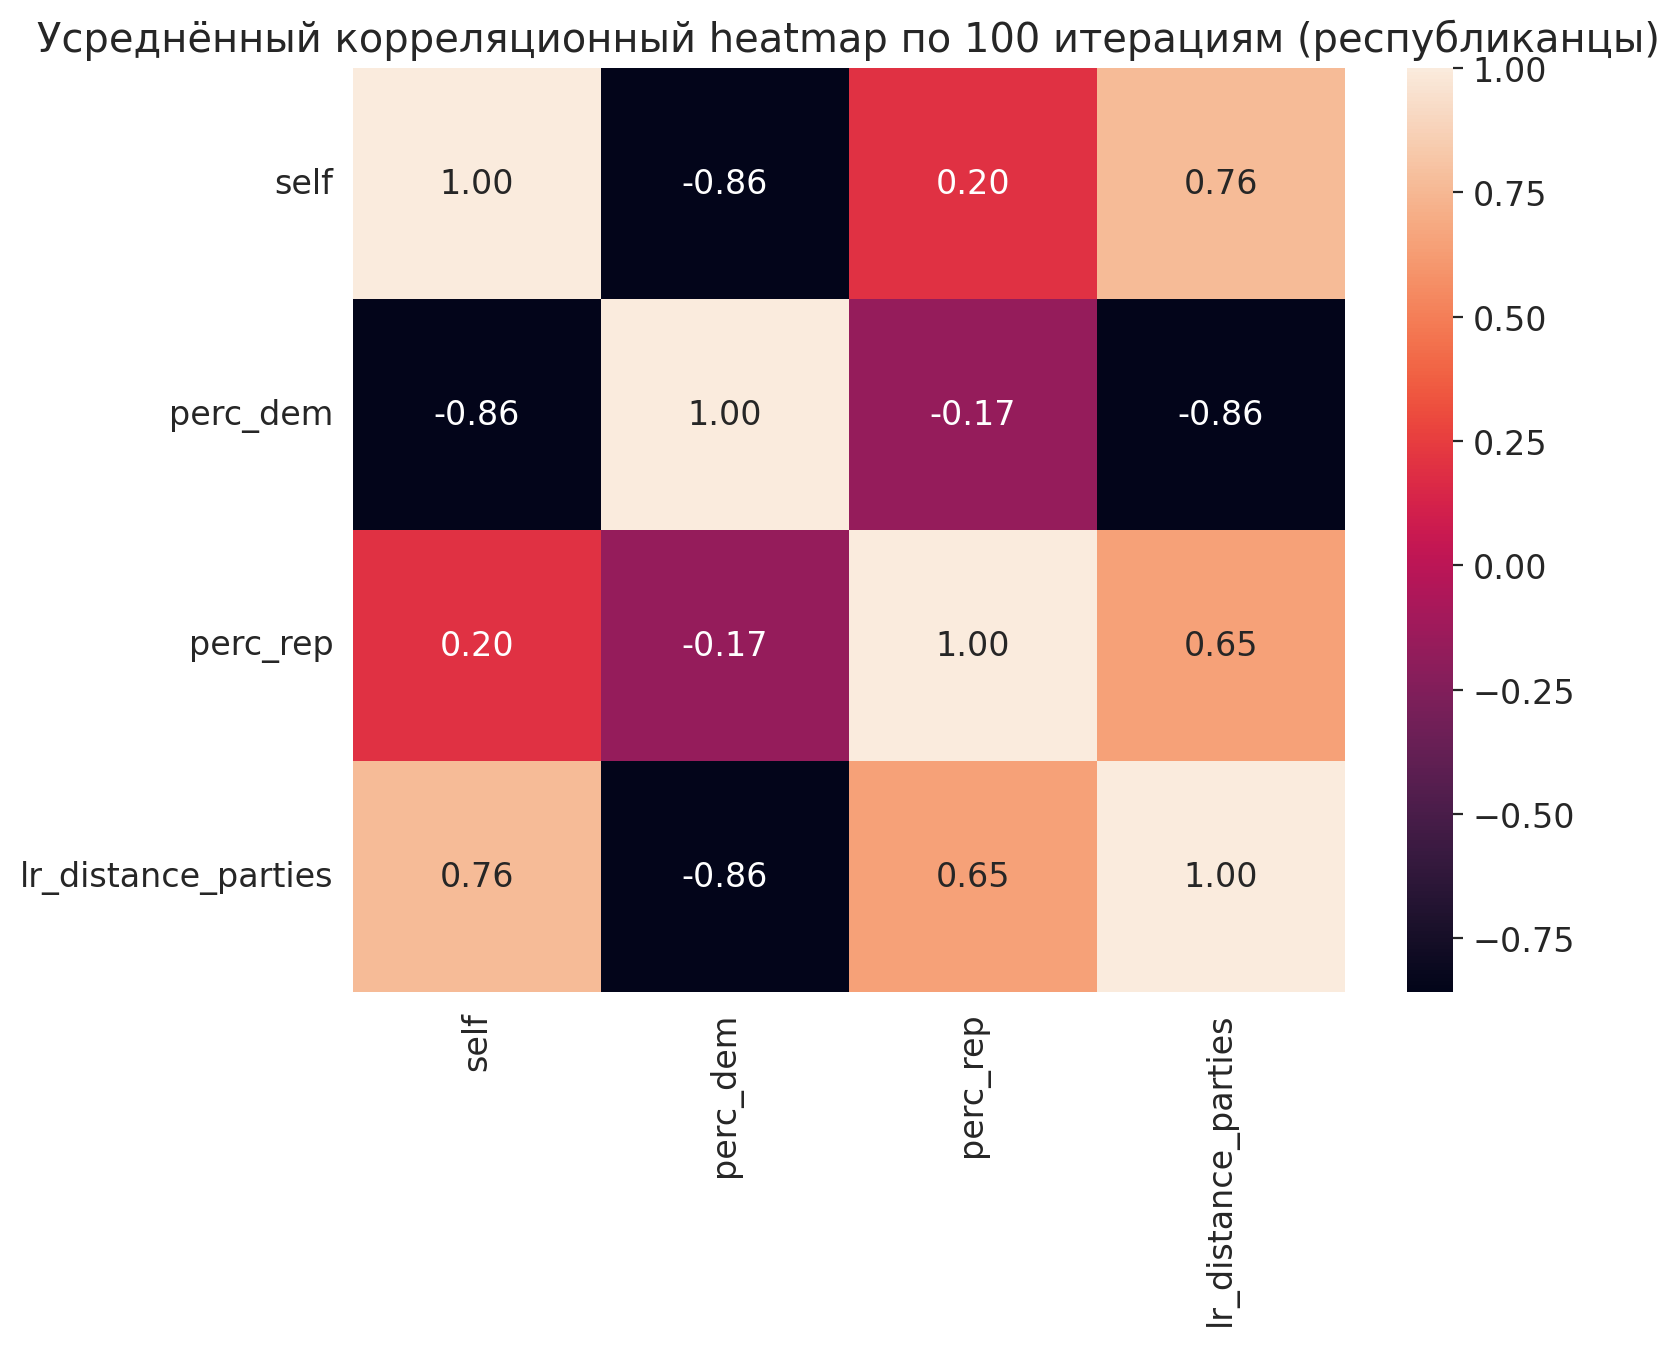

In [29]:
n_iterations = 100
corr_matrices = []

party_of_interest = 1  # 0 - Демократы, 1 - Республиканцы

for _ in range(n_iterations):
    df = model.run_single_iteration()
    df_party = df[df['party'] == party_of_interest]
    corr = df_party.corr()
    corr_matrices.append(corr)

# Averaging correlations to account for noise
mean_corr = sum(corr_matrices) / n_iterations

plt.figure(figsize=(8, 6))
sns.heatmap(mean_corr.drop(index='party', columns='party'), annot=True, fmt=".2f")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title(f"Усреднённый корреляционный heatmap по 100 итерациям (республиканцы)")
plt.show()

## Гистограммы распределений результатов модели

Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90


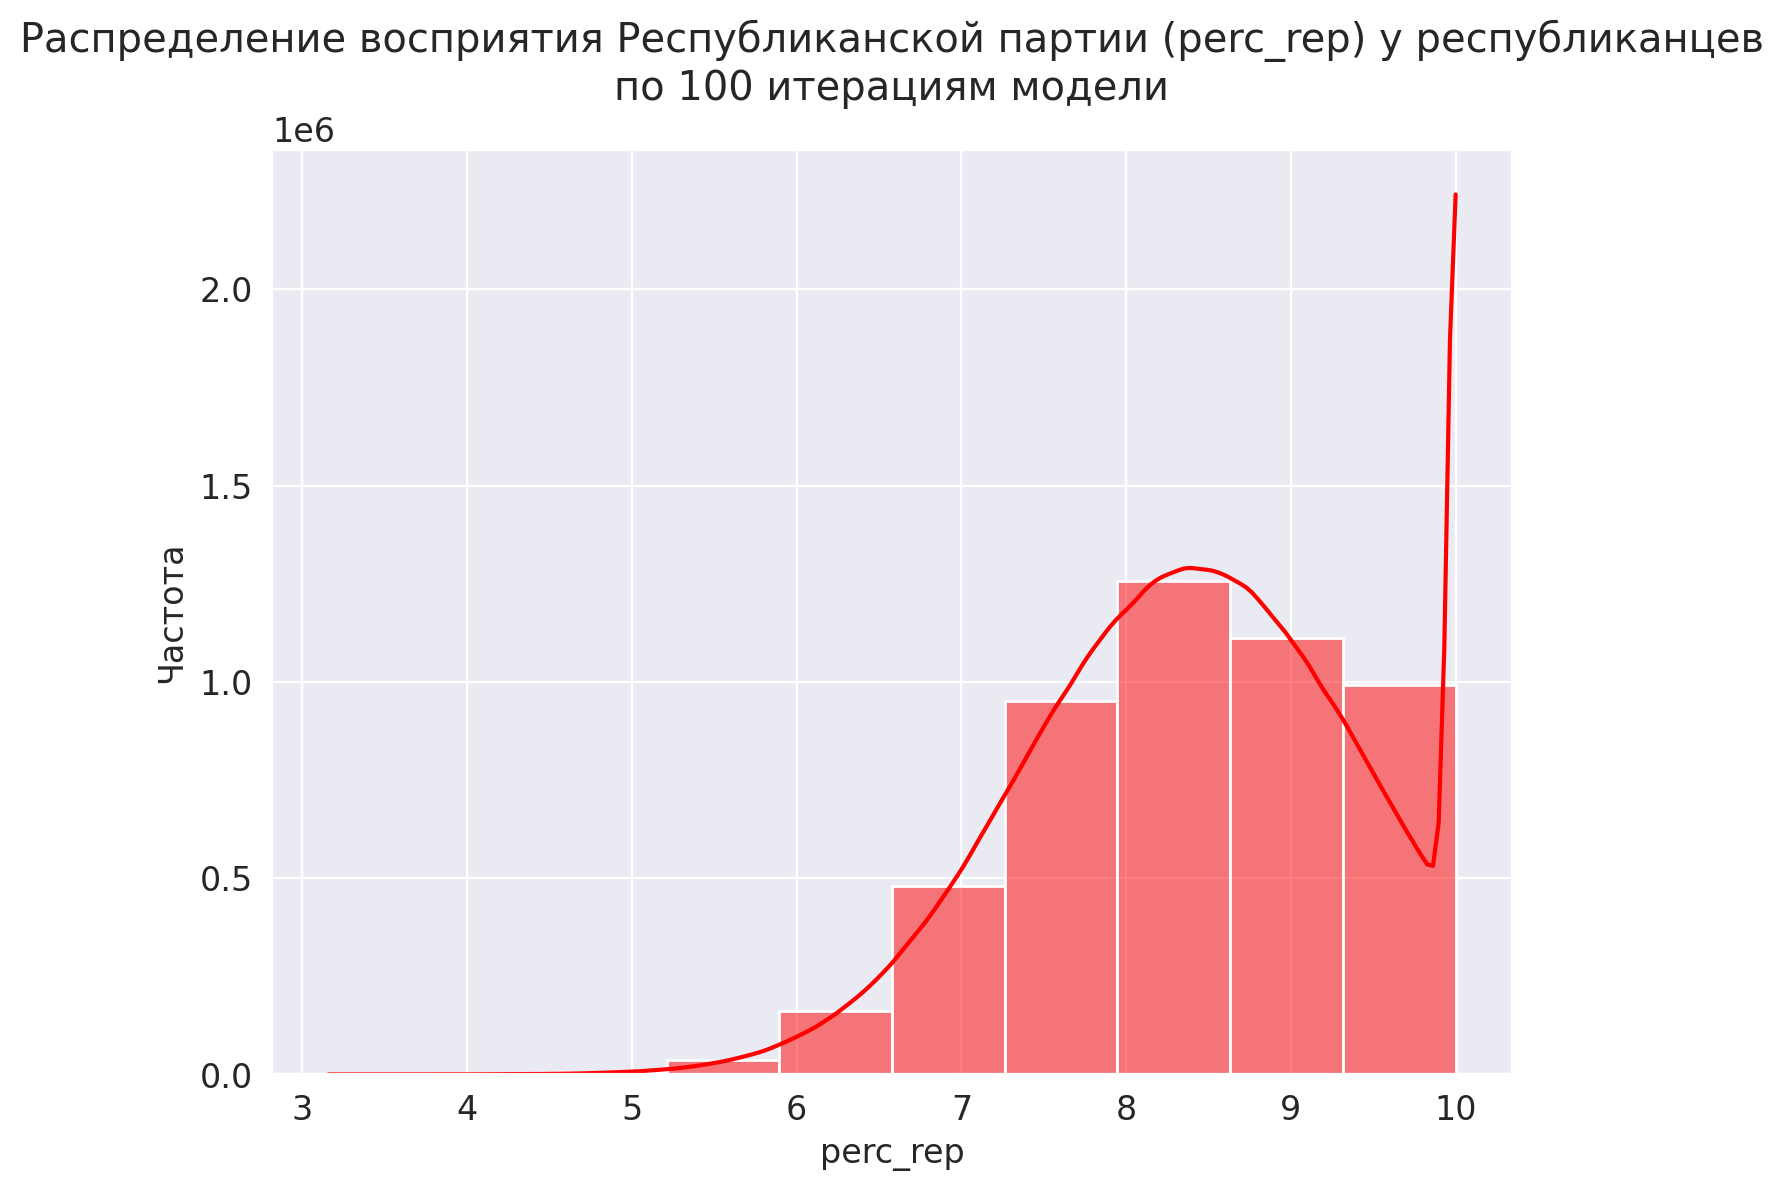

In [43]:
model = IdeologicalPolarizationModel(
    n_agents=100000,
    probability_logical_perception=0.8,
    perception_std=1.0,
    rep_pos=7,
    dem_pos=3
)

n_iterations = 100
all_perc_dem = []

for i in range(n_iterations):
    if i % 10 == 0:
        print('Iteration:', i)
    df = model.run_single_iteration()
    perc_dem_values = df[df['party'] == 1]['perc_rep']
    all_perc_dem.extend(perc_dem_values)

plt.figure(figsize=(8, 6))
sns.histplot(all_perc_dem, bins=10, kde=True, color='red')
plt.title("Распределение восприятия Республиканской партии (perc_rep) у республиканцев\nпо 100 итерациям модели")
plt.xlabel("perc_rep")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

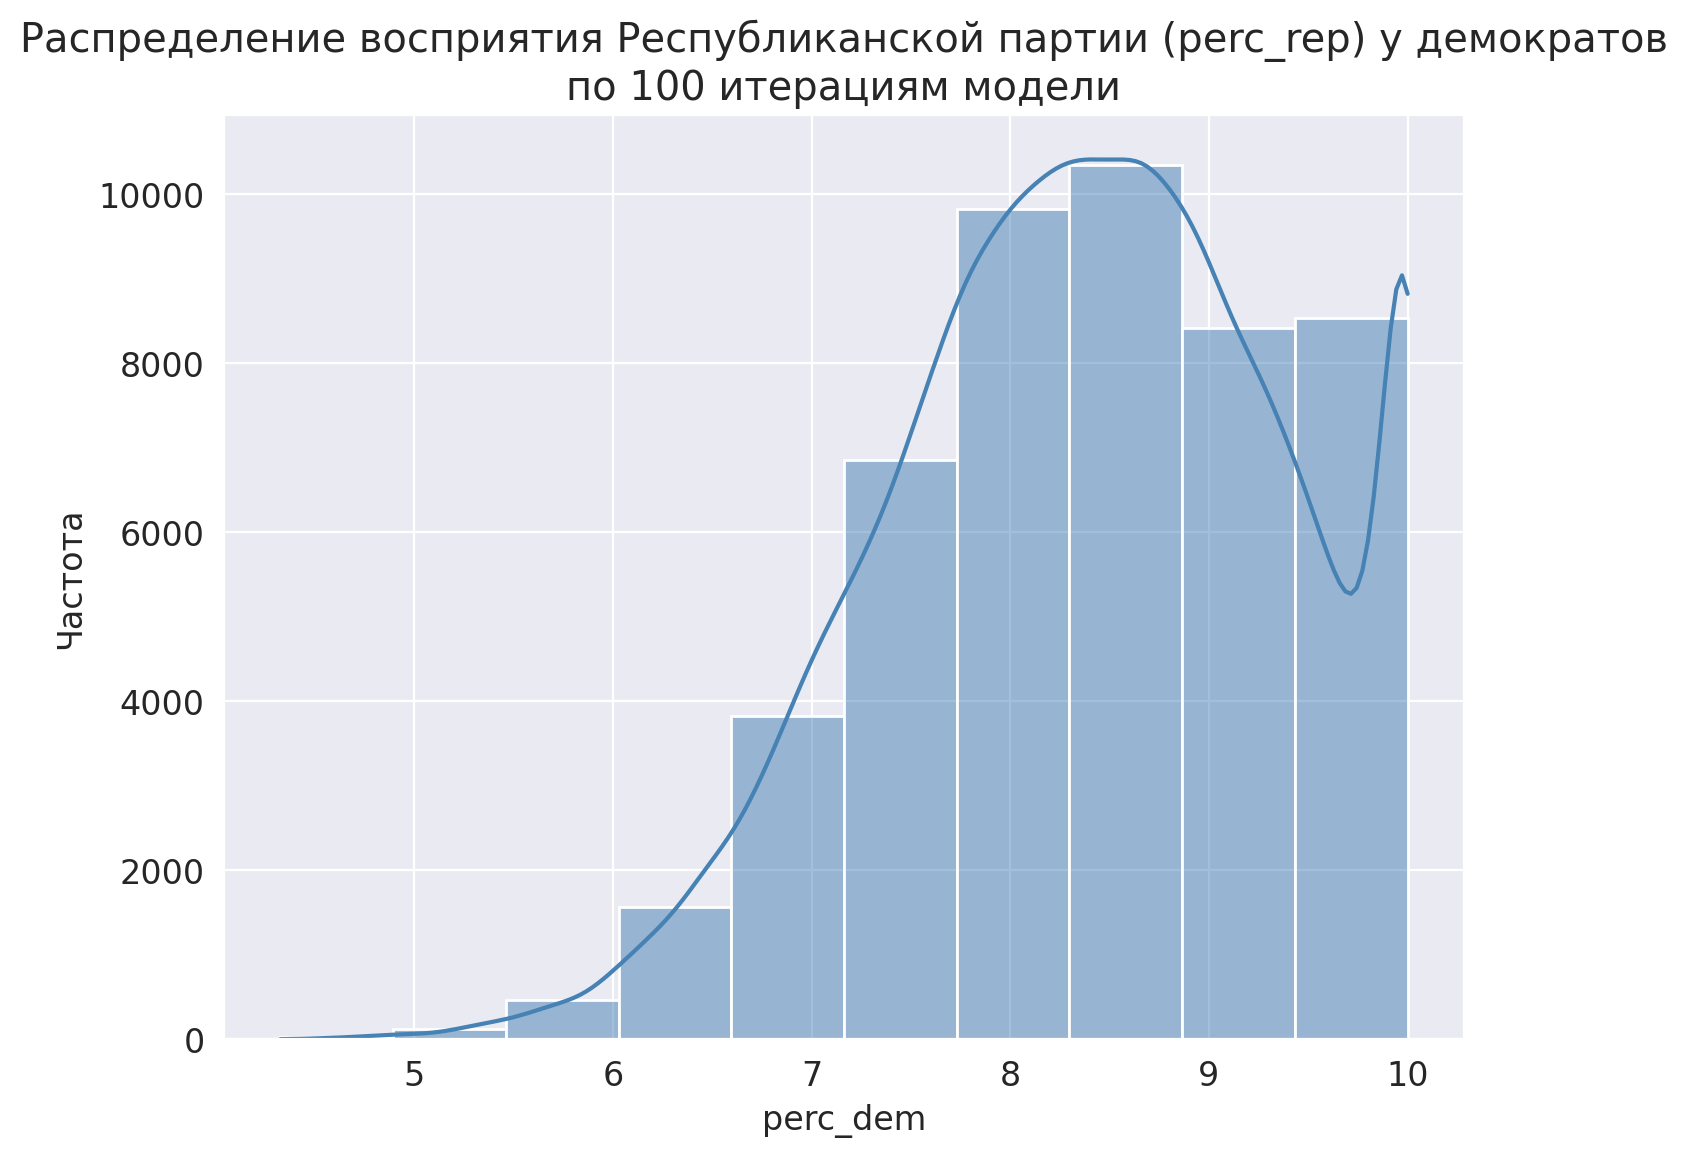

In [34]:
plt.figure(figsize=(8, 6))
sns.histplot(df[df['party'] == 1]['perc_rep'], bins=10, kde=True, color='steelblue')
plt.title("Распределение восприятия Республиканской партии (perc_rep) у демократов\nпо 100 итерациям модели")
plt.xlabel("perc_dem")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

## Boxplot'ы распределений результатов модели

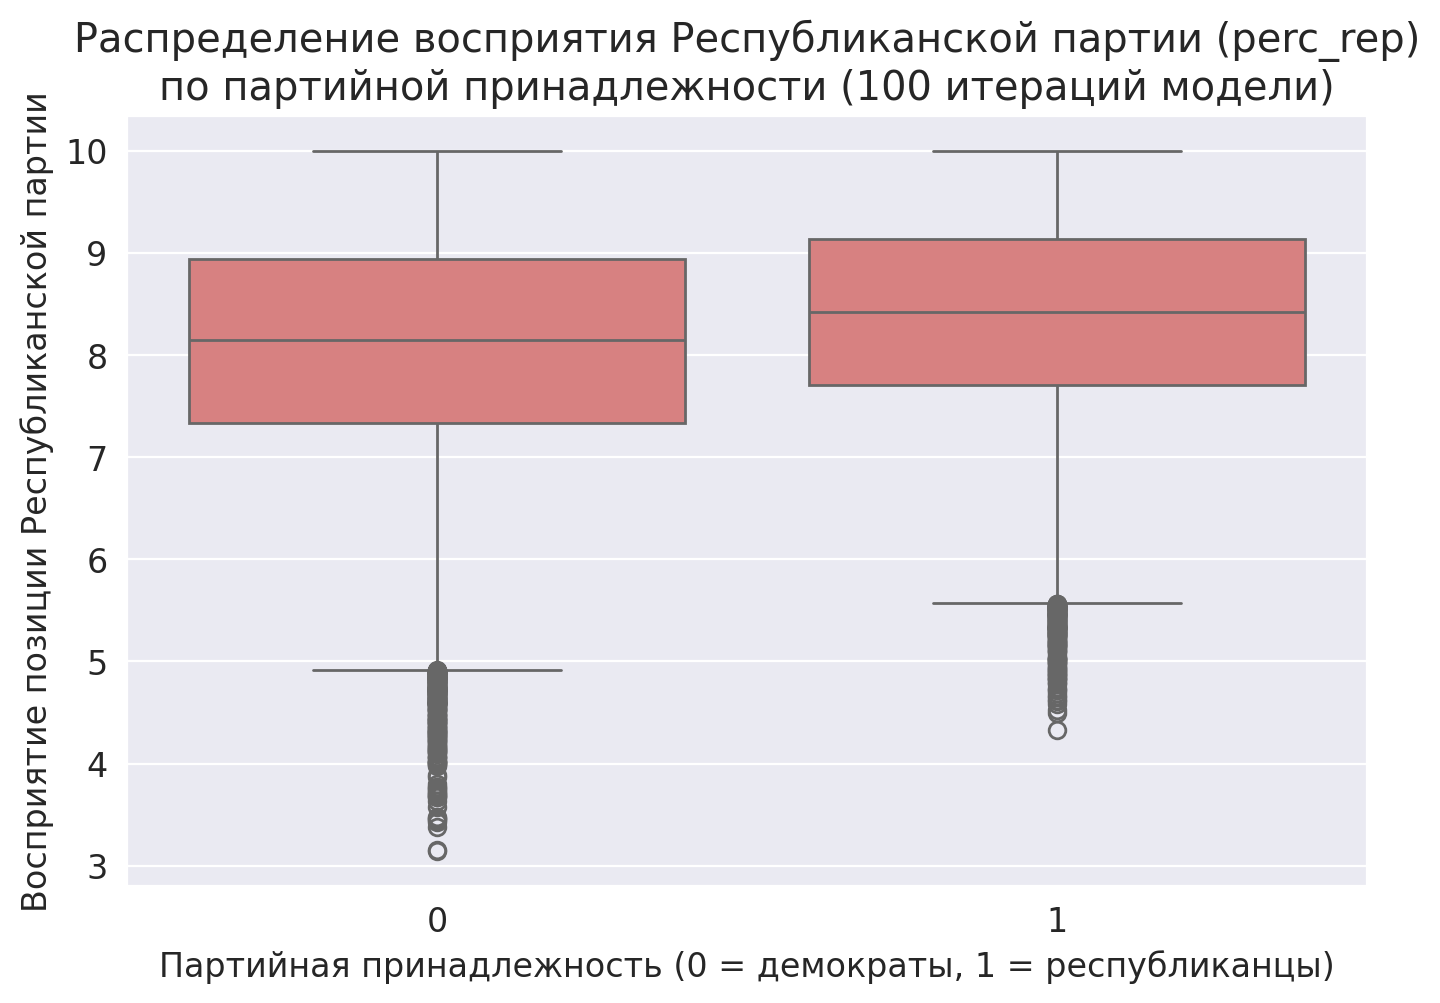

In [35]:
import matplotlib.pyplot as plt
sns.boxplot(data=df, x='party', y='perc_rep', color="#E57373")
plt.title("Распределение восприятия Республиканской партии (perc_rep)\nпо партийной принадлежности (100 итераций модели)")
plt.xlabel("Партийная принадлежность (0 = демократы, 1 = республиканцы)")
plt.ylabel("Восприятие позиции Республиканской партии")
plt.show()

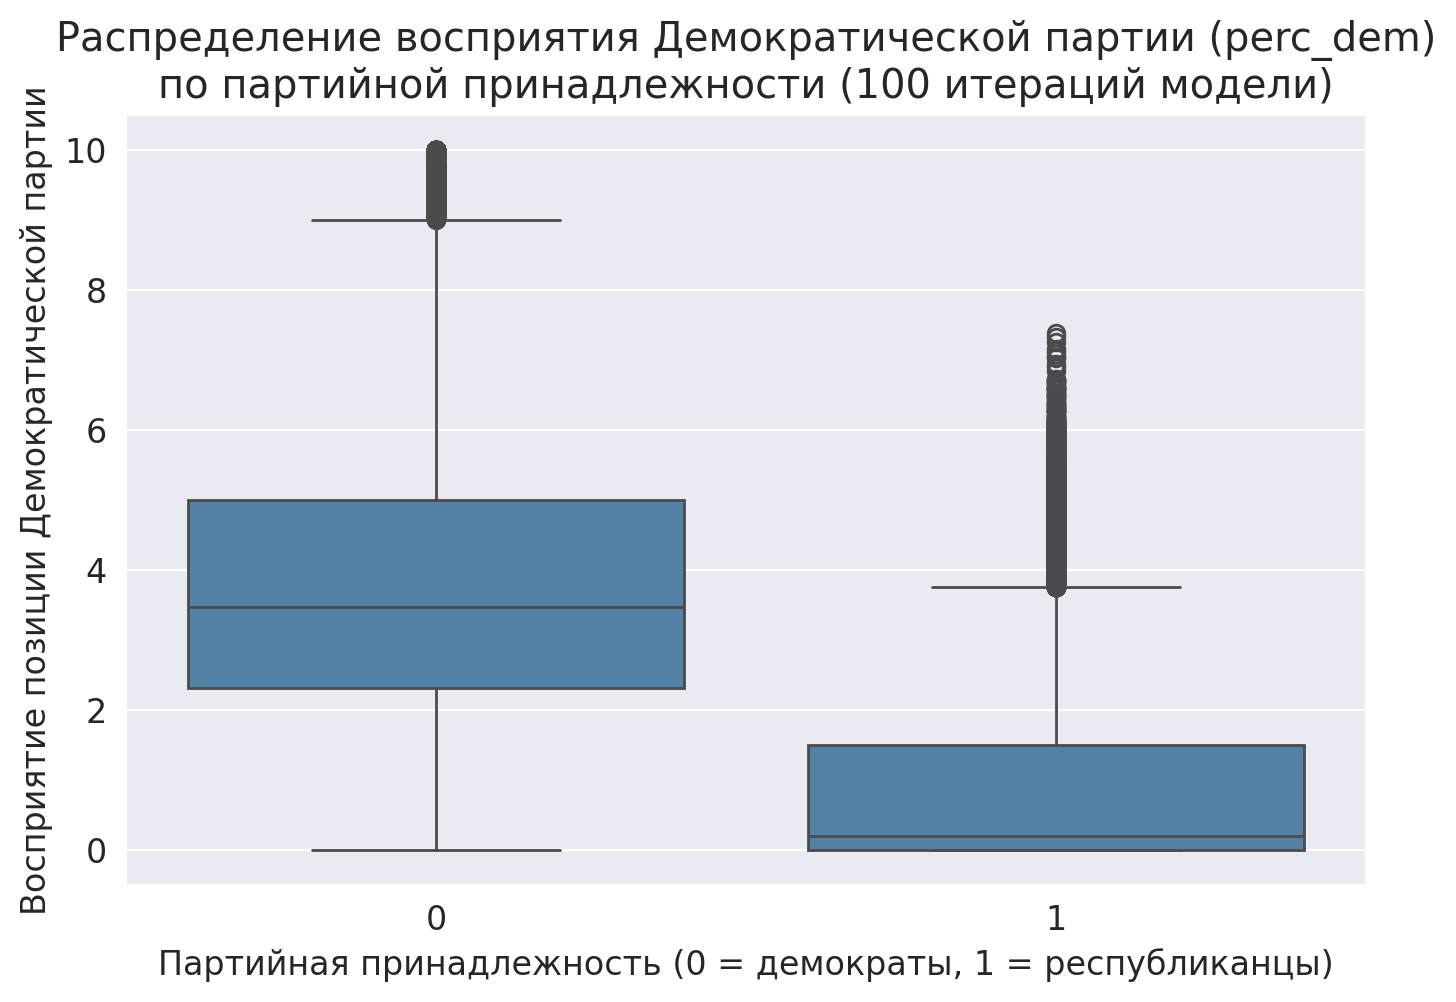

In [38]:
sns.boxplot(data=df, x='party', y='perc_dem', color='steelblue')
plt.title("Распределение восприятия Демократической партии (perc_dem)\nпо партийной принадлежности (100 итераций модели)")
plt.xlabel("Партийная принадлежность (0 = демократы, 1 = республиканцы)")
plt.ylabel("Восприятие позиции Демократической партии")
plt.show()